#  <font color='dark gary'> pyOD(python Outlier detection) - Anomaly detection method
- https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
- https://github.com/yzhao062/anomaly-detection-resources
- 응용 분야
     * Data cleaning
     * Fraud detection like credit card frauds or security breaches
     * Health monitoring of people, systems, and machines

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

# <font color='brown'> Lesson 1
## A walkthrough of Univariate Anomaly Detection in Python
- https://www.analyticsvidhya.com/blog/2021/06/univariate-anomaly-detection-a-walkthrough-in-python/

In [3]:
from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.ensemble import IsolationForest

In [4]:
# Solution 1
number_or_rows = 365*24 # hours in a year
df = pd.util.testing.makeTimeDataFrame(number_or_rows, freq="H")
df.reset_index(inplace=True)
df = df.rename(columns = {'index': 'date'})
df

,date,A,B,C,D
0,2000-01-01 00:00:00,-0.620024,0.971371,0.475947,-1.648088
1,2000-01-01 01:00:00,0.737046,-0.049661,0.501017,-2.580976
2,2000-01-01 02:00:00,0.010624,-0.516820,-1.494770,0.124815
3,2000-01-01 03:00:00,-0.844918,-0.841909,1.010978,-0.718516
4,2000-01-01 04:00:00,-1.599897,-0.078914,0.349997,-0.389636
...,...,...,...,...,...
8755,2000-12-30 19:00:00,-0.233674,-0.637995,-1.934035,0.547533
8756,2000-12-30 20:00:00,-0.318665,-0.905442,-1.220463,-0.617528
8757,2000-12-30 21:00:00,-0.725332,-0.990155,-1.246027,0.065004
8758,2000-12-30 22:00:00,-0.758742,0.174701,0.667711,0.151980


In [5]:
from scipy.stats import poisson
df['poisson'] = poisson.rvs(mu=3, size=number_or_rows)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplot:title={'center':'poisson'}>, <AxesSubplot:>]],
      dtype=object)

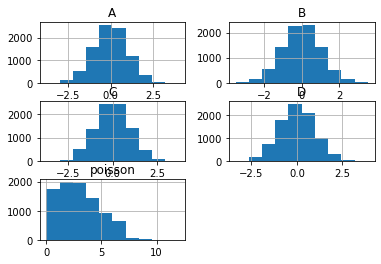

In [6]:
df.drop('date', axis=1).hist()

<AxesSubplot:>

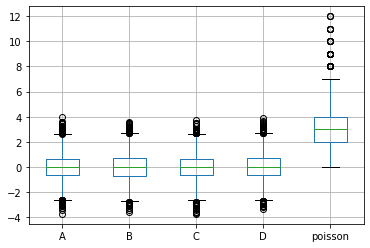

In [7]:
df.drop('date', axis=1).boxplot()

In [8]:
def fit_model(model, data, column='amount'):
    # fit the model and predict it
    df = data.copy()
    data_to_predict = data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    
    return df

def plot_anomalies(df, x='date', y='amount'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

## 1. Interquartile Range

In [9]:
def find_anomalies(value, lower_threshold, upper_threshold):
    
    if value < lower_threshold or value > upper_threshold:
        return 1
    else: return 0

def iqr_anomaly_detector(data, column='amount', threshold=1.1):
    
    df = data.copy()
    quartiles = dict(data[column].quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1

    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)

    print(f"Lower threshold: {lower_threshold}, \nUpper threshold: {upper_threshold}\n")
    
    df['Predictions'] = data[column].apply(find_anomalies, args=(lower_threshold, upper_threshold))
    
    return df

In [13]:
df
data

,date,A,B,C,D,poisson
0,2000-01-01 00:00:00,-0.620024,0.971371,0.475947,-1.648088,4
1,2000-01-01 01:00:00,0.737046,-0.049661,0.501017,-2.580976,6
2,2000-01-01 02:00:00,0.010624,-0.516820,-1.494770,0.124815,2
3,2000-01-01 03:00:00,-0.844918,-0.841909,1.010978,-0.718516,2
4,2000-01-01 04:00:00,-1.599897,-0.078914,0.349997,-0.389636,6
...,...,...,...,...,...,...
8755,2000-12-30 19:00:00,-0.233674,-0.637995,-1.934035,0.547533,1
8756,2000-12-30 20:00:00,-0.318665,-0.905442,-1.220463,-0.617528,6
8757,2000-12-30 21:00:00,-0.725332,-0.990155,-1.246027,0.065004,3
8758,2000-12-30 22:00:00,-0.758742,0.174701,0.667711,0.151980,4


,date,amount
0,2000-01-01 00:00:00,-0.620024
1,2000-01-01 01:00:00,0.737046
2,2000-01-01 02:00:00,0.010624
3,2000-01-01 03:00:00,-0.844918
4,2000-01-01 04:00:00,-1.599897
...,...,...
8755,2000-12-30 19:00:00,-0.233674
8756,2000-12-30 20:00:00,-0.318665
8757,2000-12-30 21:00:00,-0.725332
8758,2000-12-30 22:00:00,-0.758742


Lower threshold: -2.117253623508245, 
Upper threshold: 2.1213659713271555



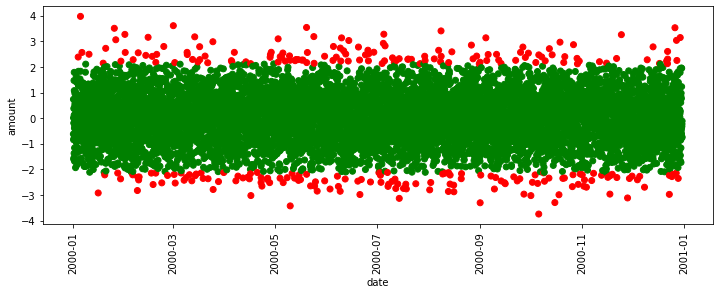

In [10]:
data = df[['date', 'A']].rename(columns = {'A': 'amount'})
iqr_df = iqr_anomaly_detector(data)
plot_anomalies(iqr_df)

## 2. Median Absolute Deviation

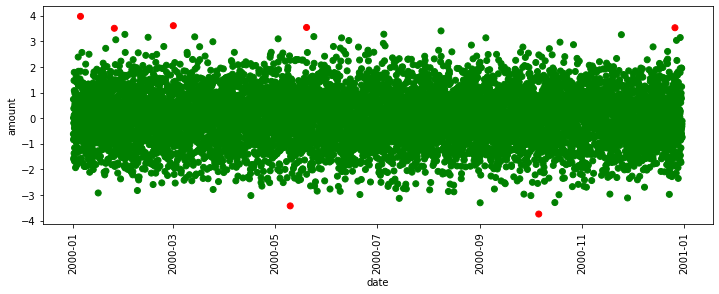

In [11]:
mad_model = MAD()
mad_df = fit_model(mad_model, data)
plot_anomalies(mad_df)

## 3. K-Nearest Neighbours algorithm

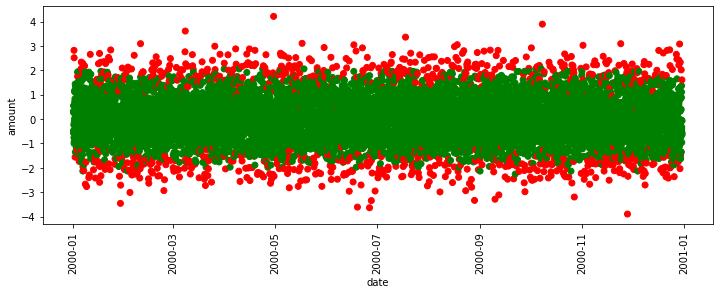

In [12]:
knn_model = KNN()
knn_df = fit_model(knn_model, data)
plot_anomalies(knn_df)

## 4. Isolation Forest

,date,amount,Predictions
0,2000-01-01 00:00:00,0.312118,1
1,2000-01-01 01:00:00,0.277799,1
2,2000-01-01 02:00:00,-0.552648,1
3,2000-01-01 03:00:00,-0.470424,1
4,2000-01-01 04:00:00,0.548402,1
...,...,...,...
8755,2000-12-30 19:00:00,-0.047988,1
8756,2000-12-30 20:00:00,1.608348,-1
8757,2000-12-30 21:00:00,-0.077740,1
8758,2000-12-30 22:00:00,-0.558805,1


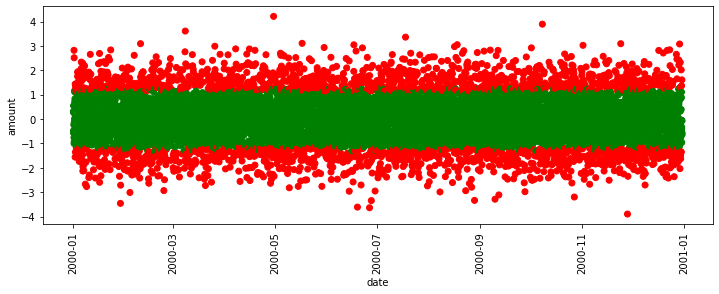

In [13]:
iso_forest = IsolationForest(n_estimators=125)
iso_df = fit_model(iso_forest, data)
iso_df
iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
plot_anomalies(iso_df)

In [14]:
data = df[['date', 'poisson']].rename(columns = {'poisson': 'amount'})
data

,date,amount
0,2000-01-01 00:00:00,4
1,2000-01-01 01:00:00,5
2,2000-01-01 02:00:00,3
3,2000-01-01 03:00:00,3
4,2000-01-01 04:00:00,3
...,...,...
8755,2000-12-30 19:00:00,4
8756,2000-12-30 20:00:00,1
8757,2000-12-30 21:00:00,4
8758,2000-12-30 22:00:00,4


이상치 검측 알고리즘 MAD(threshold=None)


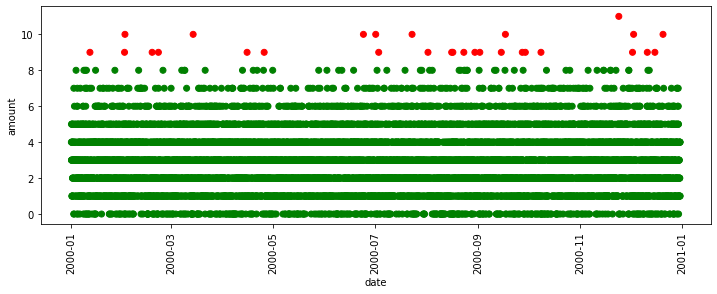

이상치 검측 알고리즘 IsolationForest(n_estimators=125)


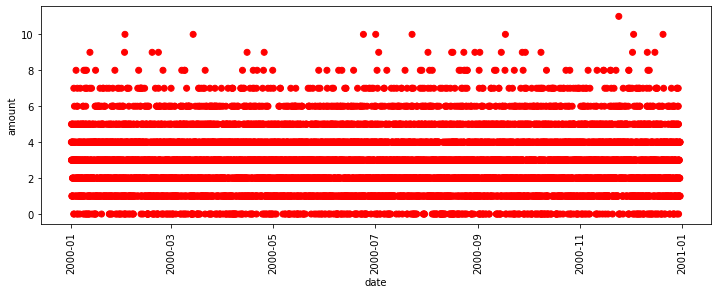

이상치 검측 알고리즘 KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)


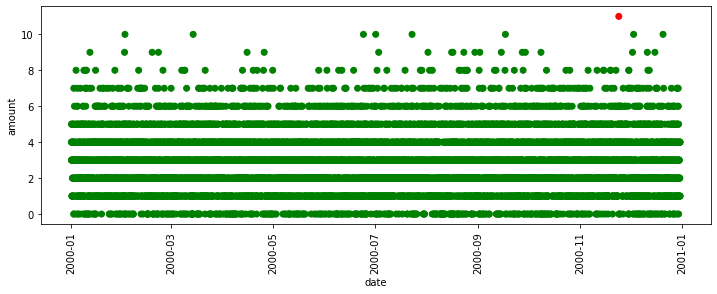

In [15]:
anomlay_detectors = [MAD(), IsolationForest(n_estimators=125), KNN()]
for detector in anomlay_detectors:
    print(f'이상치 검측 알고리즘 {detector}')
    plot_anomalies(fit_model(detector, data))

# <font color='brown'> Lesson 2
- 출처 : https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
## 1. PyOD on the data generated

In [16]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [17]:
from pyod.utils.data import generate_data, get_outliers_inliers
#generate_data?

### np.random.seed(1024)는 moon형태로 에러가 많음

In [18]:
#generate random data with two features
np.random.seed(1023)
X_train, Y_train = generate_data(n_train=200, train_only=True, n_features=2)

df = pd.DataFrame(X_train, columns = ['x1', 'x2'])
df['class'] = Y_train
df['class'].value_counts()
df.head()

0.0    180
1.0     20
Name: class, dtype: int64

,x1,x2,class
0,7.112180,7.333623,0.0
1,6.805015,8.596611,0.0
2,6.891287,7.085767,0.0
3,7.861260,5.151316,0.0
4,6.650760,7.382807,0.0


array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>],
       [<AxesSubplot:title={'center':'class'}>, <AxesSubplot:>]],
      dtype=object)

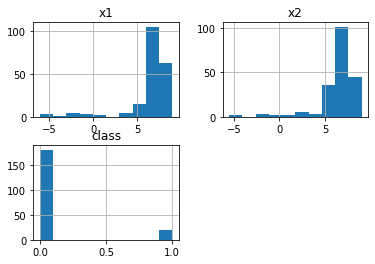

In [19]:
df.hist()

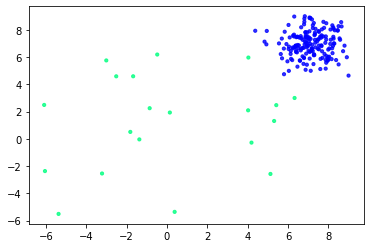

In [20]:
#fig, ax = plt.subplots()
plt.scatter(df['x1'], df['x2'], c=df['class'], s=10, alpha=0.8, cmap='winter')

정상자료 180개, 비정상자료 20개


Text(0.5, 0, 'F1')

Text(0, 0.5, 'F2')

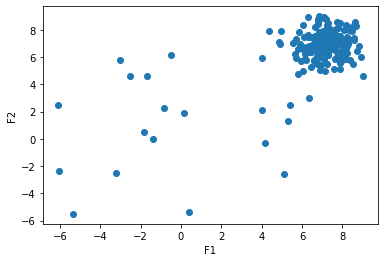

In [21]:
# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train, Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

print(f'정상자료 {n_inliers}개, 비정상자료 {n_outliers}개')


#separate the two features and use it to plot the data 
F1 = X_train[:,[0]]#.reshape(-1,1)
F2 = X_train[:,[1]]#.reshape(-1,1)
# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1'); plt.ylabel('F2') 

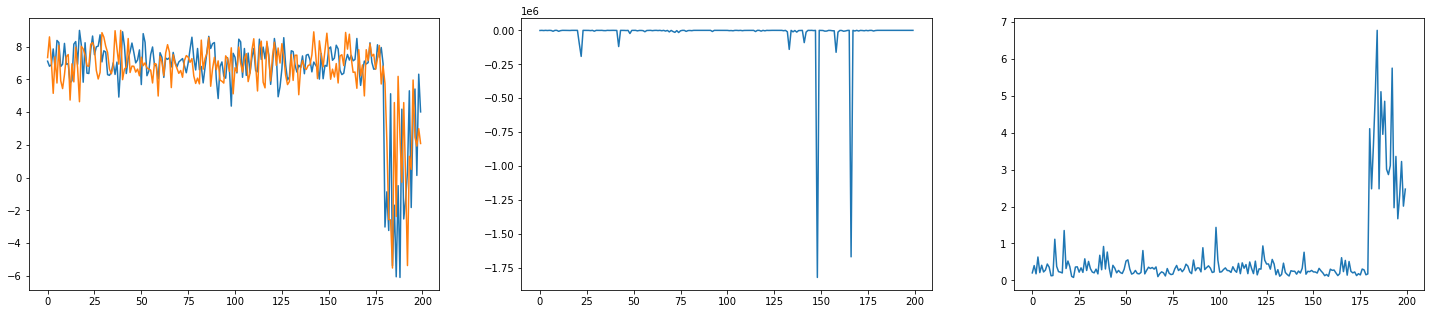

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))
ax[0].plot(X_train)
ax[1].plot(ABOD(contamination=outlier_fraction).fit(X_train).decision_function(X_train))
ax[2].plot(KNN(contamination=outlier_fraction).fit(X_train).decision_function(X_train))

In [23]:
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

for clf_name, clf in classifiers.items() :
    scores_pred = clf.fit(X_train).decision_function(X_train)
    threshold = stats.scoreatpercentile(scores_pred,100*outlier_fraction) # cut-off value를 높일 수 있음
    print(f'{clf_name}모델 예측시 기준값보다 적은 자료: {np.sum((scores_pred <= threshold))*1}개')
    y_pred = clf.fit(X_train).predict(X_train)
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)
    print('*'*100)

Angle-based Outlier Detector (ABOD)모델 예측시 기준값보다 적은 자료: 20개
No of Errors :  Angle-based Outlier Detector (ABOD) 3
****************************************************************************************************
K Nearest Neighbors (KNN)모델 예측시 기준값보다 적은 자료: 20개
No of Errors :  K Nearest Neighbors (KNN) 0
****************************************************************************************************


<Figure size 1080x576 with 0 Axes>

ABOD(contamination=0.1, method='fast', n_neighbors=5)

No of Errors :  Angle-based Outlier Detector (ABOD) 3


(-10.0, 10.0, -10.0, 10.0)

Text(0.5, 1.0, 'Angle-based Outlier Detector (ABOD)')

(-10.0, 10.0)

(-10.0, 10.0)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

No of Errors :  K Nearest Neighbors (KNN) 0


(-10.0, 10.0, -10.0, 10.0)

Text(0.5, 1.0, 'K Nearest Neighbors (KNN)')

(-10.0, 10.0)

(-10.0, 10.0)

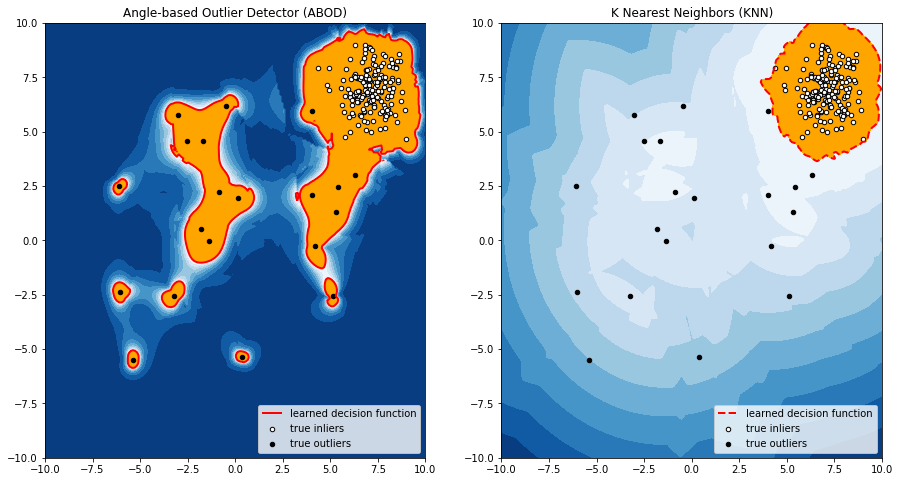

In [24]:
#set the figure size
plt.figure(figsize=(15, 8))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show()

## 2. PyOD on the Big Mart Sales Problem
- source : https://www.kaggle.com/devashish0507/big-mart-sales-prediction
- script source : https://www.analyticsvidhya.com/blog/2021/06/univariate-anomaly-detection-a-walkthrough-in-python/

In [25]:
df = pd.read_csv('../data/Train.csv')
df.shape
df.head()

(8523, 12)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

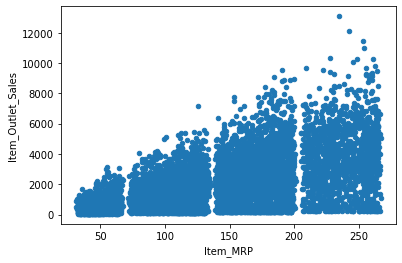

In [26]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


In [28]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)
X

array([[0.92750715, 0.28358666],
       [0.0720684 , 0.03141895],
       [0.46828841, 0.15811486],
       ...,
       [0.22849221, 0.08885035],
       [0.30493925, 0.13883505],
       [0.18750976, 0.05610527]])

In [29]:
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [30]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        #'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

ABOD(contamination=0.05, method='fast', n_neighbors=5)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'Angle-based Outlier Detector (ABOD)')

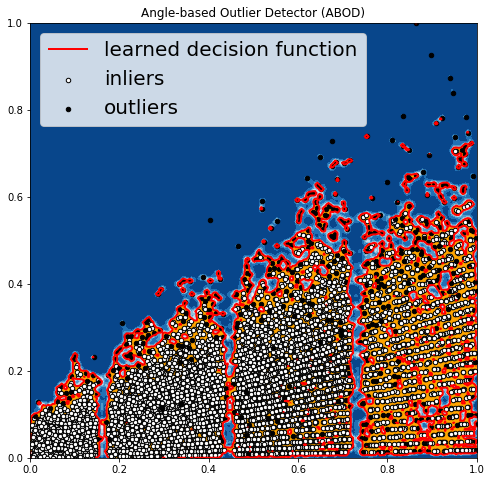

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=1,
   random_state=RandomState(MT19937) at 0x297AF10C440, use_weights=False)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'Cluster-based Local Outlier Factor (CBLOF)')

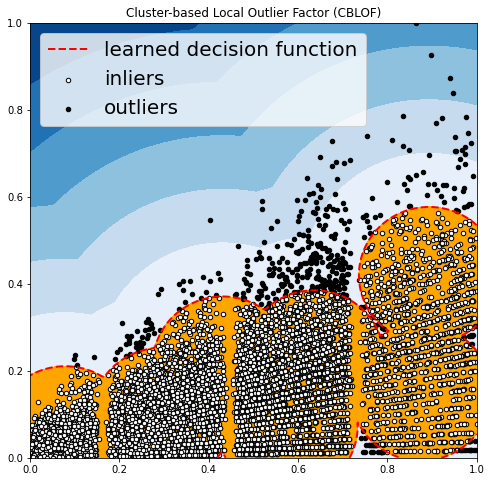

HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'Histogram-base Outlier Detection (HBOS)')

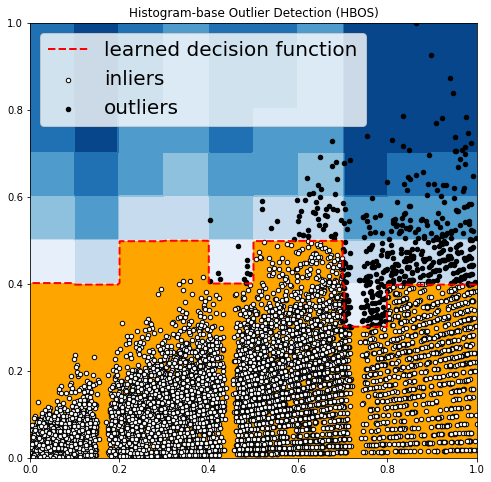

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=RandomState(MT19937) at 0x297AF10C440, verbose=0)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  426 INLIERS :  8097 Isolation Forest


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'Isolation Forest')

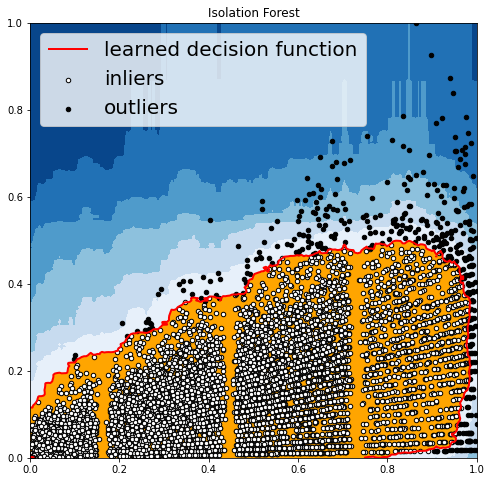

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'K Nearest Neighbors (KNN)')

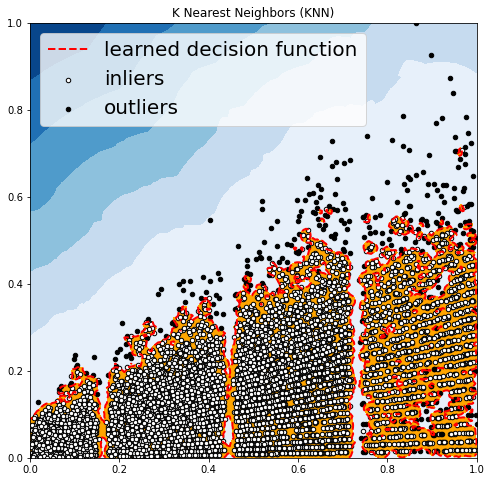

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

<Figure size 576x576 with 0 Axes>

OUTLIERS :  176 INLIERS :  8347 Average KNN


(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'Average KNN')

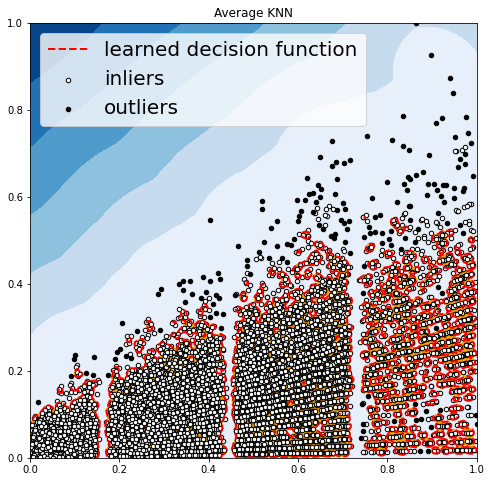

In [31]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(8, 8))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

# End